# Exercice sur le PIB des Etats-Unis

Installation des packages

In [1]:
install.packages("data.table")
install.packages('ggplot2')
install.packages('urca')
install.packages('lmtest')
install.packages('sandwich')
#sessionInfo()
#install.packages("https://git.nomics.world/dbnomics/rdbnomics")
remotes::install_github("dbnomics/rdbnomics", build_vignettes = TRUE, force = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




curl (5.0.2 -> 5.1.0) [CRAN]


Installing 1 packages: curl

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpO5l8bq/remotes269e17ef29/dbnomics-rdbnomics-a1db6e5/DESCRIPTION’ ... OK
* preparing ‘rdbnomics’:
* checking DESCRIPTION meta-information ... OK
* installing the package to build vignettes
* creating vignettes ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rdbnomics_0.6.4.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Importation et visualisation des données


On importe les données trimestrielles du PIB des Etats-Unis du 01/01/1947 au 23/01/01 (305 observations). Les données sont importées du site db.nomics. Les données proviennent du \`\`Bureau of Labor Statistics''. On les importe en utilisant leur identifiant ids.

In [3]:
library(data.table)
library(rdbnomics)

df<-rdb(ids = "BEA/NIPA-T10106/A191RX-Q")
#class(df)
str(df)

Visit <https://db.nomics.world>.



Classes ‘data.table’ and 'data.frame':	306 obs. of  19 variables:
 $ @frequency     : chr  "quarterly" "quarterly" "quarterly" "quarterly" ...
 $ concept        : chr  "gross-domestic-product" "gross-domestic-product" "gross-domestic-product" "gross-domestic-product" ...
 $ Concept        : chr  "Gross domestic product" "Gross domestic product" "Gross domestic product" "Gross domestic product" ...
 $ dataset_code   : chr  "NIPA-T10106" "NIPA-T10106" "NIPA-T10106" "NIPA-T10106" ...
 $ dataset_name   : chr  "Table 1.1.6. Real Gross Domestic Product, Chained Dollars - LastRevised: September 28, 2023" "Table 1.1.6. Real Gross Domestic Product, Chained Dollars - LastRevised: September 28, 2023" "Table 1.1.6. Real Gross Domestic Product, Chained Dollars - LastRevised: September 28, 2023" "Table 1.1.6. Real Gross Domestic Product, Chained Dollars - LastRevised: September 28, 2023" ...
 $ FREQ           : chr  "Q" "Q" "Q" "Q" ...
 $ Frequency      : chr  "Quarterly" "Quarterly" "Quarterly" "Qu

On crée un dataframe contenant uniquement les dates (colonne period) à partir du premier trimestre de l'année 1990 et la série du PIB (colonne value).

In [4]:
df_Y_us<-df[df$period>="1990-01-01",c("period","value")]
colnames(df_Y_us)<-c('Date','PIB')

In [5]:
head(df_Y_us)

Date,PIB
<date>,<dbl>
1990-01-01,10047386
1990-04-01,10083855
1990-07-01,10090569
1990-10-01,9998704
1991-01-01,9951916
1991-04-01,10029510


In [6]:
tail(df_Y_us)

Date,PIB
<date>,<dbl>
2022-01-01,21738871
2022-04-01,21708160
2022-07-01,21851134
2022-10-01,21989981
2023-01-01,22112329
2023-04-01,22225350


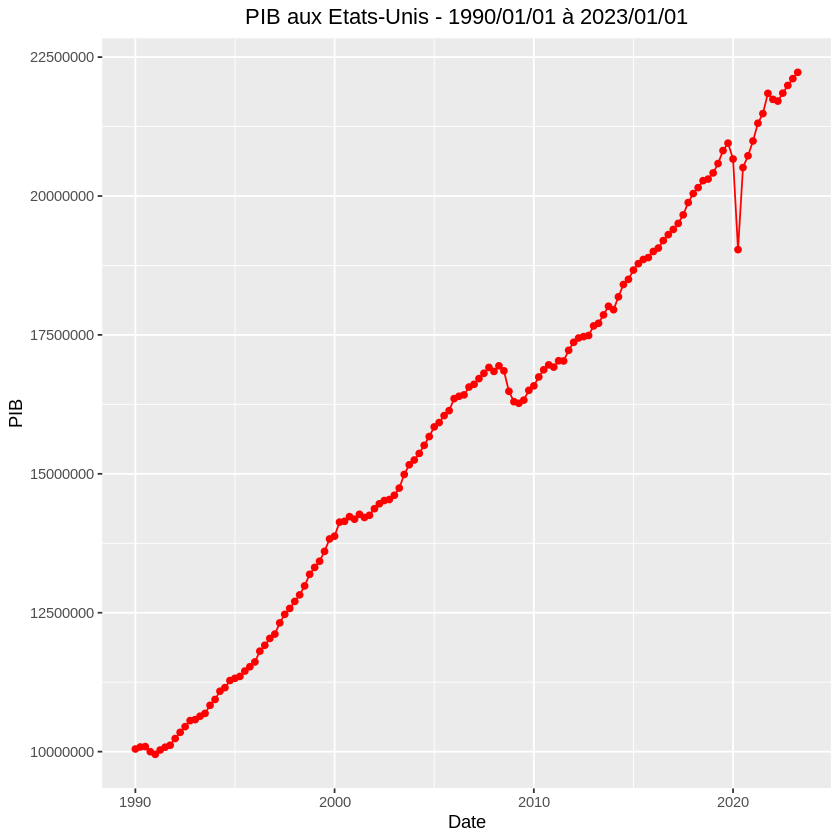

In [7]:
library(ggplot2)
p_us<-ggplot(data=df_Y_us,aes(x=Date,y=PIB))+geom_point(color='red')+geom_line(color='red')+xlab('Date')+ylab('PIB')+ggtitle('PIB aux Etats-Unis - 1990/01/01 à 2023/01/01')+theme(plot.title = element_text(hjust = 0.5))
p_us

Le graphique montre que le PIB augmente de façon tendantielle au cours de la période, avec cependant une baisse de niveau en 2009, due à la grande récession et un creux très prononcé au moment de déclenchement de l'épidémie de COVID. On va exclure dans un premier temps la période du COVID de l'échantillon et l'inclure par la suite pour voir son impact sur les résultats de tests de racine unitaire et de stationnarité.



### Visualisation du PIB en logarithme



On applique la fonction logarithme au PIB. Les tests de racine unitaire et de stationnarité seront appliqués au PIB en logarithme.

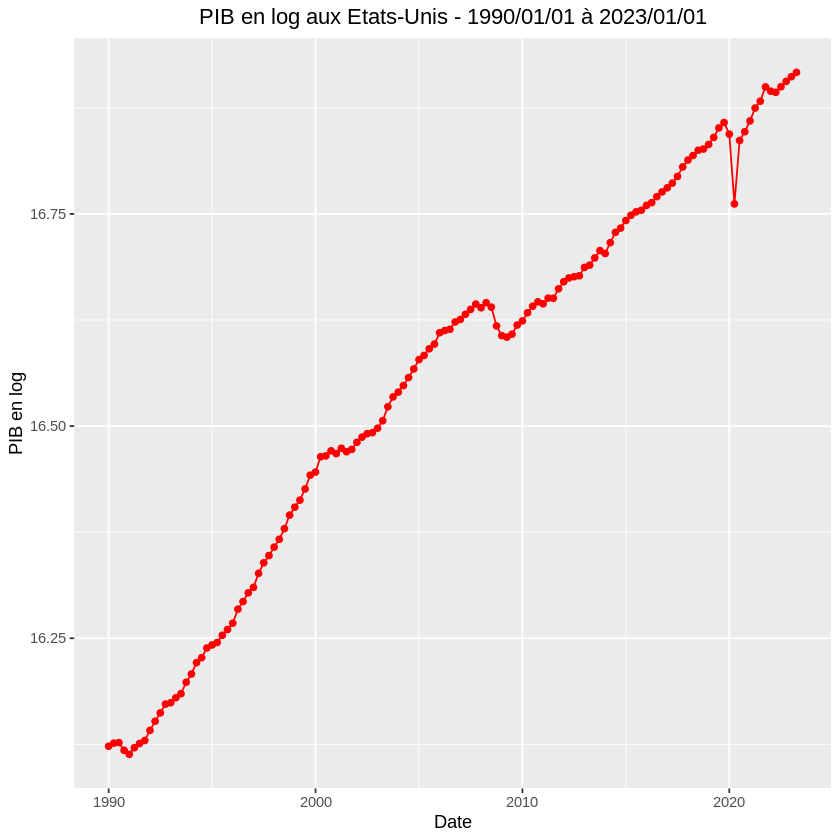

In [8]:
df_Y_us$logPIB<-log(df_Y_us$PIB)
library(ggplot2)
p_us<-ggplot(data=df_Y_us,aes(x=Date,y=logPIB))+geom_point(color='red')+geom_line(color='red')+xlab('Date')+ylab('PIB en log')+ggtitle('PIB en log aux Etats-Unis - 1990/01/01 à 2023/01/01')+theme(plot.title = element_text(hjust = 0.5))
p_us

## Tests sans la période Covid



On exclut les observations postérieures au premier semestre de l'année 2020. Les résultats des tests de racine unitaire et de stationnarité ne sont modifiés. On peut dire aussi qu'ils sont robustes à cette modification de la période de test.

In [14]:
df_Y_us_bc=df_Y_us[df_Y_us$Date<"2020-01-01",]

### Autocorrélogramme du log du PIB

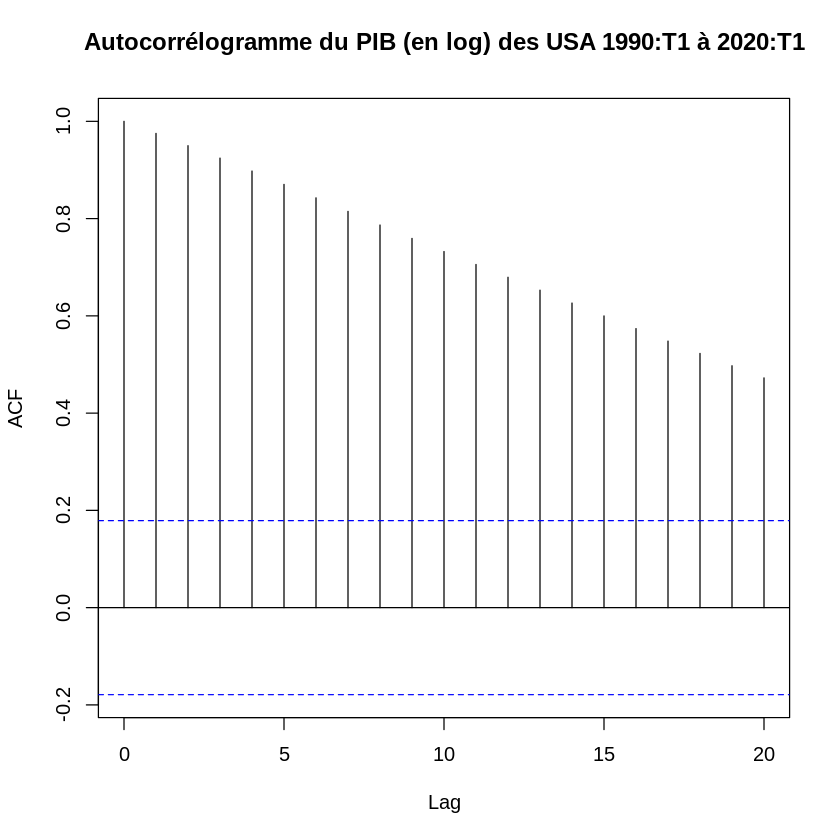

In [15]:
acf_us_rate<-acf(x=df_Y_us_bc$logPIB,main='Autocorrélogramme du PIB (en log) des USA 1990:T1 à 2020:T1')

Les autocorrélations sont toutes significatives et proches de 1 pour les premiers décalages. Elles décroissent relativement lentement.

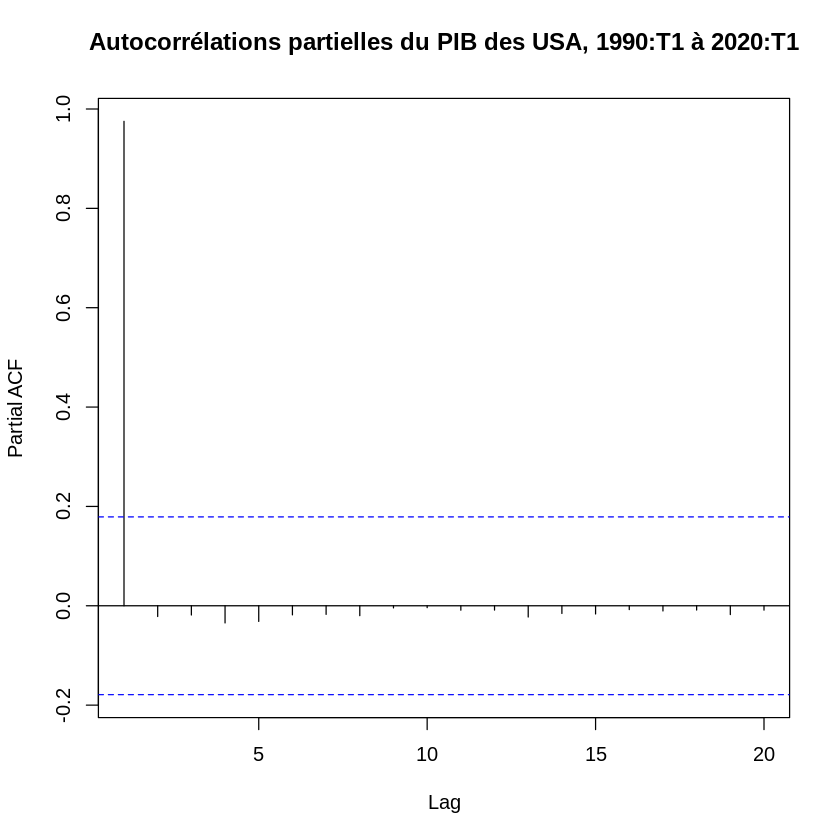

In [16]:
pacf(x=df_Y_us_bc$logPIB,main='Autocorrélations partielles du PIB des USA, 1990:T1 à 2020:T1')

Aucune autocorrélation partielle n'est significativement différente de 0.



### Test de Dickey-Fuller augmenté



#### Test ADF avec constante et tendance déterministe



On applique le test ADF avec une tendance déterministe. Le nombre de retards maximum est fixé à 8 et le nombre de retards optimal est déterminé par la minimisation du critère AIC.

In [19]:
library(urca)
adf1<-ur.df(y = df_Y_us_bc$logPIB,type=c("trend"), lag=8, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0241963 -0.0027391  0.0004169  0.0027255  0.0111003 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  4.190e-01  2.113e-01   1.983  0.04995 * 
z.lag.1     -2.564e-02  1.308e-02  -1.961  0.05255 . 
tt           1.328e-04  7.977e-05   1.665  0.09896 . 
z.diff.lag1  2.669e-01  9.344e-02   2.856  0.00516 **
z.diff.lag2  1.979e-01  9.376e-02   2.111  0.03712 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005115 on 106 degrees of freedom
Multiple R-squared:  0.2199,	Adjusted R-squared:  0.1905 
F-statistic: 7.472 on 4 and 106 DF,  p-value: 2.426e-05


Value of test-statistic is: -1.9606 6.7575 2.7542 

Critical

La statistique du test ADF est égale à $t_{ADF}=-1.961$. Les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire.

Le t-stat de la tendance déterministe est égal à $t_{\hat{b}} = 1.983$. Le seuil de rejet qui figurent la table de $t_{\hat{b}}$ est égal à 3.14 pour un risque de première espèce de 5% et 100 observations. on a donc $\vert t_{\hat{b}} \vert = 1.983 <3.14$ : on ne peut pas rejeter l'hypothèse nulle que la tendance déterministe n'est pas significative.


#### Test ADF avec constante

In [20]:
adf2<-ur.df(y = df_Y_us_bc$logPIB,type=c("drift"), lag=8, selectlags = c('AIC'))
summary(adf2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0248862 -0.0027659  0.0005032  0.0029389  0.0101559 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.074759   0.043629   1.714  0.08951 . 
z.lag.1     -0.004308   0.002625  -1.641  0.10372   
z.diff.lag1  0.269327   0.094200   2.859  0.00511 **
z.diff.lag2  0.184739   0.094194   1.961  0.05245 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005157 on 107 degrees of freedom
Multiple R-squared:  0.1996,	Adjusted R-squared:  0.1771 
F-statistic: 8.892 on 3 and 107 DF,  p-value: 2.589e-05


Value of test-statistic is: -1.6411 8.6085 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -

La statistique du test ADF est égale à $t_{ADF}=-1.641$. Les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire.

Le t-stat de la constante est égal à $t_{\hat{c}} = 1.714$. Le seuil de rejet de la table de $t_{\hat{c}}$ est égal à 2.86 pour un risque de première espèce de 5% et T=100 observations. on a donc $\vert t_{\hat{c}} \vert = 1.714<2.86$ : on ne peut pas rejeter l'hypothèse nulle que la contante n'est pas significative.



#### Test ADF sans constante ni tendance déterministe

In [21]:
adf3<-ur.df(y = df_Y_us_bc$logPIB,type=c("none"), lag=8, selectlags = c('AIC'))
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0249709 -0.0029751  0.0004449  0.0030827  0.0103928 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
z.lag.1     1.893e-04  5.055e-05   3.746 0.000291 ***
z.diff.lag1 2.991e-01  9.341e-02   3.202 0.001796 ** 
z.diff.lag2 2.126e-01  9.361e-02   2.271 0.025133 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005203 on 108 degrees of freedom
Multiple R-squared:  0.6424,	Adjusted R-squared:  0.6325 
F-statistic: 64.67 on 3 and 108 DF,  p-value: < 2.2e-16


Value of test-statistic is: 3.7456 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


La statistique du test ADF est égale à $t_{ADF}=3.746$. Les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire. On conclut que la série n'est pas stationnaire.

#### Conclusion



Les résultats des tests ADF nous amènent à conclure que le PIB (en log) des Etats-Unis est une série DS sans tendance ni constante. On dit aussi qu'elle est un processus DS sans dérive (drift).



### Test de stationnarité de KPSS



On applique le test de stationnarité de KPSS. On présente les résultats du test avec une tendance déterministe. La représentation graphique du PIB montre que la série pourrait être stationnaire autour d'une tendance déterministe.

In [22]:
kpss_mu<-ur.kpss(y=df_Y_us_bc$logPIB,type="tau",lags="short")
summary(kpss_mu)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.5206 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


La statistique du test KPSS avec une constante est égale à $LM_{KPSS} = 0.5664$. Elle est supérieure au seuil de rejet à 5% : $$ 0.5206>0.146$$ (et aussi à celle à 1%). On rejette l'hypothèse nulle de stationnarité du taux du PIB autour d'une tendance déterministe.

In [23]:
kpss_tau<-ur.kpss(y=df_Y_us_bc$logPIB,type="mu",lags="short")
summary(kpss_tau)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 2.4163 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Les résultats des tests de stationarité autour d'une constante montre que l'on rejette également l'hypothèse de stationnarité.

### Conclusion générale sur les test de racine unitaire et de stationnarité



Les tests ADF et KPSS rejettent tous la stationnarité du PIB des Etats-Unis. On étudie l'impact de la chute brutale et temporaire du PIB lors du début de l'épidémie de COVID sur les résultats des tests de racine unitaire et de stationnarité.

## Test sur la période 1990:Q1 à 2023:Q1

### Autocorrélogramme du log du PIB

, , 1

           [,1]
 [1,] 1.0000000
 [2,] 0.9767032
 [3,] 0.9535504
 [4,] 0.9300858
 [5,] 0.9057353
 [6,] 0.8808201
 [7,] 0.8555319
 [8,] 0.8297592
 [9,] 0.8043637
[10,] 0.7792998
[11,] 0.7549581
[12,] 0.7312302
[13,] 0.7080505
[14,] 0.6881769
[15,] 0.6639208
[16,] 0.6386211
[17,] 0.6138553
[18,] 0.5895674
[19,] 0.5659595
[20,] 0.5423505
[21,] 0.5188712
[22,] 0.4953954

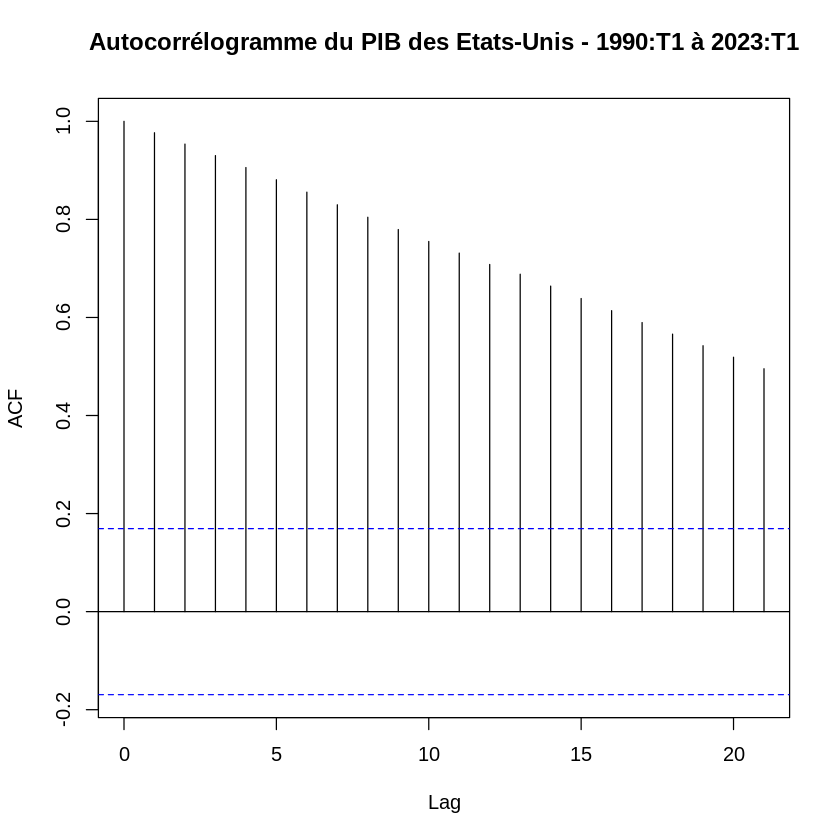

In [24]:
acf_us_rate<-acf(x=df_Y_us$logPIB,main='Autocorrélogramme du PIB des Etats-Unis - 1990:T1 à 2023:T1')
acf_us_rate$acf

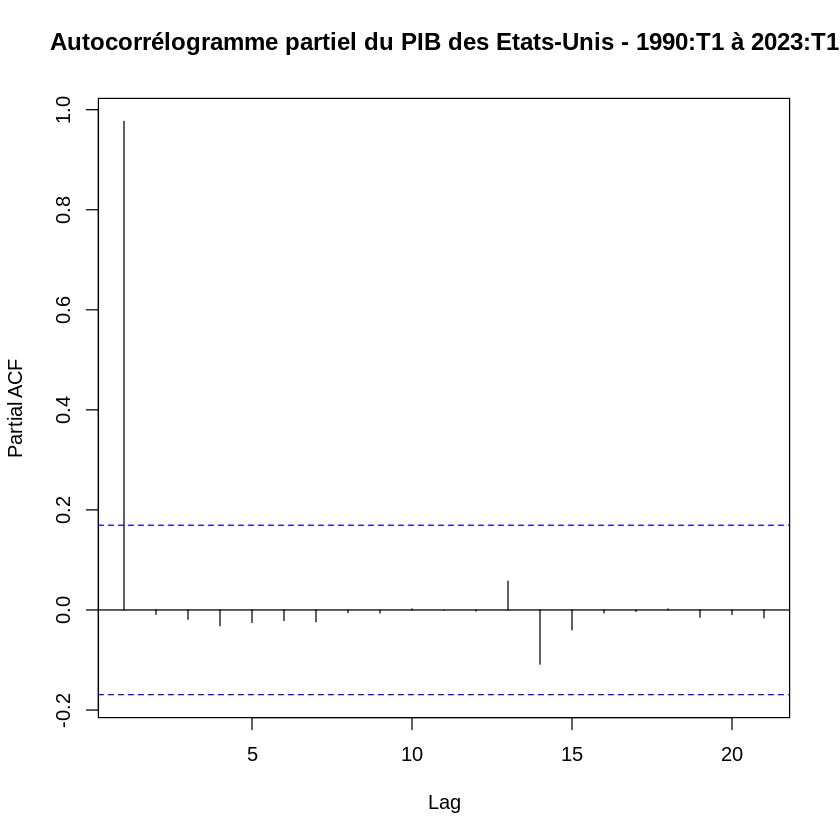

In [25]:
pacf(x=df_Y_us$logPIB,main='Autocorrélogramme partiel du PIB des Etats-Unis - 1990:T1 à 2023:T1')

### Test de Dickey-Fuller augmenté

On applique le test ADF avec une tendance déterministe. Le nombre de retards maximum est fixé à 8 et le nombre de retards optimal est déterminé par la minimisation du critère AIC.

In [26]:
library(urca)
adf1<-ur.df(y = df_Y_us$logPIB,type=c("trend"), lag=8, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.090384 -0.002457  0.000955  0.003442  0.051169 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.9447620  0.4374374   2.160   0.0328 *
z.lag.1     -0.0578089  0.0270647  -2.136   0.0347 *
tt           0.0002900  0.0001592   1.821   0.0710 .
z.diff.lag  -0.1508835  0.0883567  -1.708   0.0903 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01136 on 121 degrees of freedom
Multiple R-squared:  0.07697,	Adjusted R-squared:  0.05408 
F-statistic: 3.363 on 3 and 121 DF,  p-value: 0.021


Value of test-statistic is: -2.136 15.1798 3.5182 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.99 -3.43 -3

La statistique du test ADF est égale à $t_{ADF}=-2.136$. Les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire.

Le t-stat de la tendance déterministe est égal à $t_{\hat{b}} = 2.160$. Le seuil de rejet qui figurent la table de $t_{\hat{b}}$ est égal à 3.14 pour un risque de première espèce de 5%. on a donc $\vert t_{\hat{b}} \vert =  2.160 <3.14$ : on ne peut pas rejeter l'hypothèse nulle que la tendance déterministe n'est pas significative.

In [27]:
adf2<-ur.df(y = df_Y_us$logPIB,type=c("drift"), lag=8, selectlags = c('AIC'))
summary(adf2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.089298 -0.002441  0.001053  0.003695  0.055225 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.161423   0.080762   1.999   0.0479 *
z.lag.1     -0.009300   0.004868  -1.910   0.0584 .
z.diff.lag  -0.169985   0.088562  -1.919   0.0573 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01147 on 122 degrees of freedom
Multiple R-squared:  0.05166,	Adjusted R-squared:  0.03611 
F-statistic: 3.323 on 2 and 122 DF,  p-value: 0.03934


Value of test-statistic is: -1.9103 20.7173 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -2.57
phi1  6.52  4.63  3.81


La statistique du test ADF est égale à $t_{ADF}=-1.910$ les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire.

Le t-stat de la constante est égal à $t_{\hat{c}} = 1.999$. Le seuil de rejet de la table de $t_{\hat{c}}$ est égal à 2.86 pour un risque de première espèce de 5%. on a donc $\vert t_{\hat{c}} \vert = 1.999<2.86$ : on ne peut pas rejeter l'hypothèse nulle que la contante n'est pas significative.

In [28]:
adf3<-ur.df(y = df_Y_us$logPIB,type=c("none"), lag=8, selectlags = c('AIC'))
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.091495 -0.001852  0.000334  0.004427  0.055164 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
z.lag.1     4.294e-04  7.103e-05   6.046 1.65e-08 ***
z.diff.lag -1.505e-01  8.909e-02  -1.689   0.0938 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0116 on 123 degrees of freedom
Multiple R-squared:  0.2374,	Adjusted R-squared:  0.225 
F-statistic: 19.15 on 2 and 123 DF,  p-value: 5.753e-08


Value of test-statistic is: 6.0456 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


La statistique du test ADF est égale à $t_{ADF}=6.046$. Les seuils de rejet figurent sur la ligne tau3. La statistique de test $t_{ADF}$ est supérieure aux seuils de rejets pour les risques de première espèce de 1%, 5% et 10%. On ne peut pas rejeter l'hypothèse nulle de racine unitaire. On conclut que la série n'est pas stationnaire.



### Test de stationnarité de KPSS

On applique le test de stationnarité de KPSS. On présente les résultats du test avec une constante. La représentation graphique de la série et les conclusions du test ADF montrent que la taux de chômage ne contient pas de tendance déterministe. On ne rejette pas l'hypothèse nulle de stationnarité autour d'une constante.

In [29]:
kpss_tau<-ur.kpss(y=df_Y_us$logPIB,type="tau",lags="short")
summary(kpss_tau)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.542 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


On rejette à nouveau l'hypothèse de stationnarité autour d'une tendance déterministe.

In [30]:
kpss_mu<-ur.kpss(y=df_Y_us$logPIB,type="mu",lags="short")
summary(kpss_mu)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 2.6856 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


On rejette l'hypothèse de stationnarité autour d'une constante.



## Etude du PIB en différence première

La différence première du PIB en log correspond à son taux de croissance (voir l'exercice sur le CAC40 pour une explication).

In [31]:
df_gY_us<-data.frame(df_Y_us$Date[-1],diff(df_Y_us$logPIB))
df_gY_us_y<-data.frame(df_Y_us$Date[-1],4*100*diff(df_Y_us$logPIB))# taux annualisé en %
colnames(df_gY_us)<-c('Date','gY')
which.min(df_gY_us$gY)

[1] 121

In [32]:
tail(df_gY_us)

,Date,gY
,<date>,<dbl>
128,2022-01-01,-0.004989219
129,2022-04-01,-0.001413722
130,2022-07-01,0.006564593
131,2022-10-01,0.006334121
132,2023-01-01,0.005548386
133,2023-04-01,0.005098203


### Représentation graphique du taux de croissance du PIB des Etats-Unis

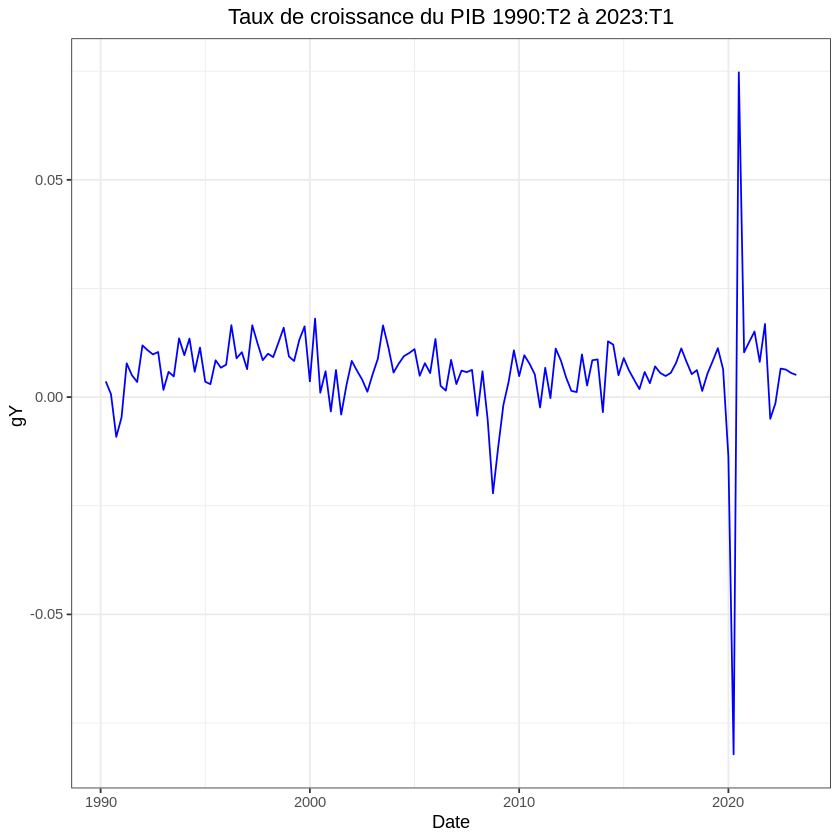

In [33]:
p<-ggplot(data=df_gY_us,aes(x=Date,y=gY))+geom_line(colour='blue')+ ggtitle('Taux de croissance du PIB 1990:T2 à 2023:T1') +xlab('Date')+ ylab('gY ')+theme_bw()+theme(plot.title = element_text(hjust = 0.5))
p

Le graphique du taux de croissance du PIB montre trois observations atypiques : la baisse due à la crise de 2008, la baisse encore plus forte due à la crise du COVID et le rebond qui s'en est suivi.

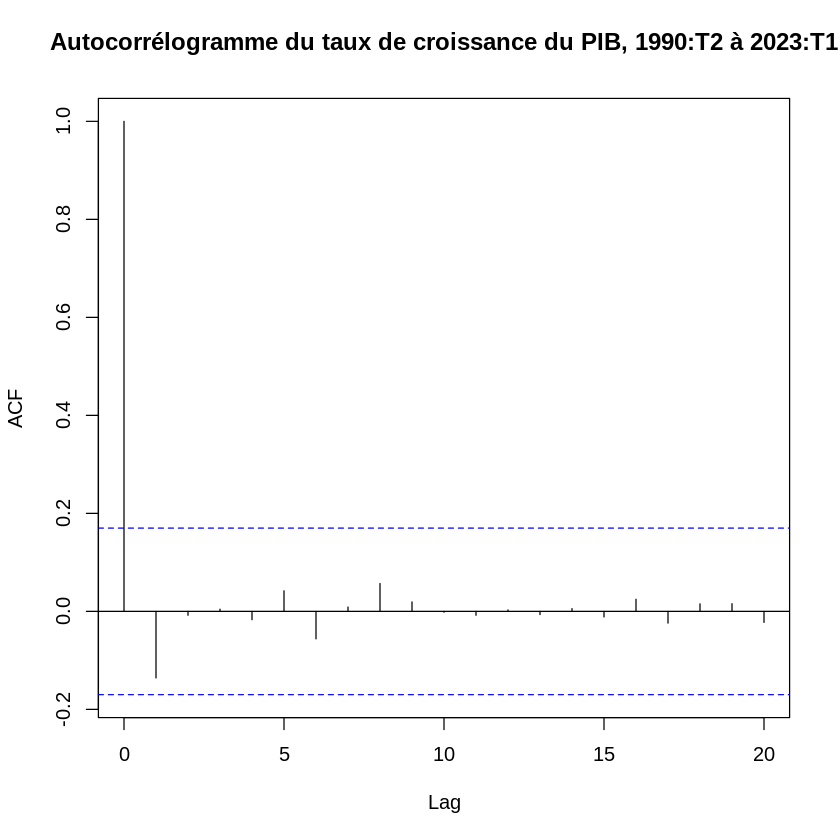

In [34]:
acf(x = df_gY_us$gY,lag.max = 20, main="Autocorrélogramme du taux de croissance du PIB, 1990:T2 à 2023:T1")

Aucune des autocorrélations estimées n'est significativement différente de 0.

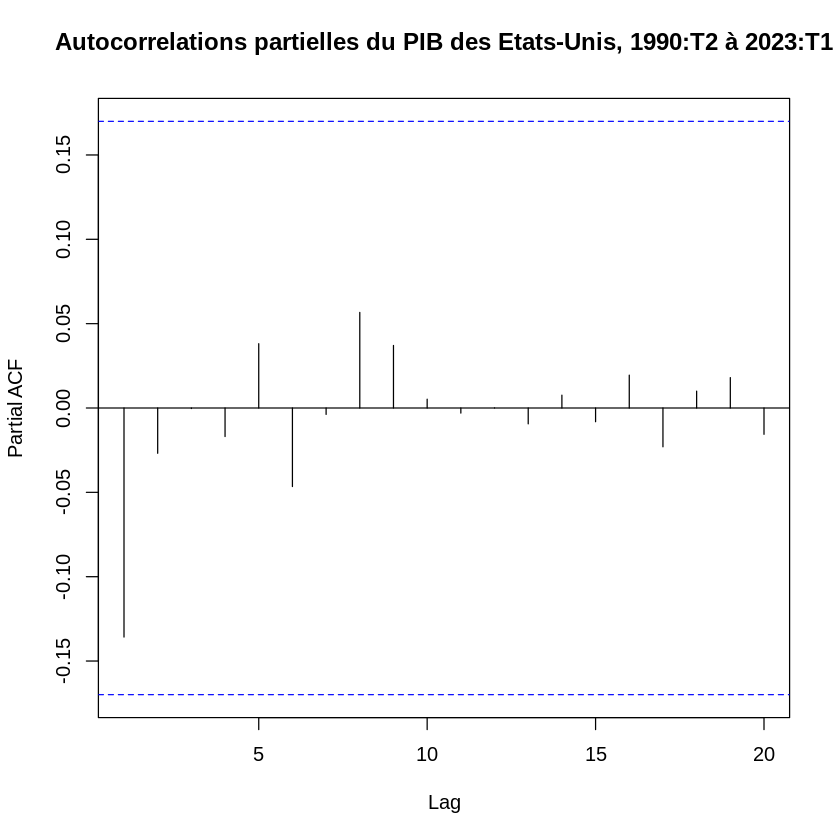

In [35]:
pacf(x = df_gY_us$gY,lag.max = 20,main='Autocorrelations partielles du PIB des Etats-Unis, 1990:T2 à 2023:T1')

Aucune des autocorrélations partielles n'est significativement différente de 0.